## Set Up

In [1]:
import enum
import math

import torch
import numpy as np
import torch.nn as nn
import torch.nn.functional as F

## collecting and preparing data

In [2]:
import zipfile
import sys
import os
import requests
import pandas as pd
import pickle
from torch.utils.data import DataLoader, Dataset

In [3]:
%pwd

'/home/alinezhad.f'

### downloading the data (should only need to do this once)

In [4]:
# os.makedirs("data_project/", exist_ok=True)
# url = "https://www.microsoft.com/en-us/research/wp-content/uploads/2016/06/STMVL-Release.zip"
# urlData = requests.get(url).content
# filename = "data_project/STMVL-Release.zip"
# with open(filename, mode="wb") as f:
#     f.write(urlData)
# with zipfile.ZipFile(filename) as z:
#     z.extractall("data_project/pm25")
        
def create_normalizer_pm25():
    df = pd.read_csv(
        "/home/alinezhad.f/data_project/pm25/STMVL-Release/Code/STMVL/SampleData/pm25_ground.txt",
        index_col="datetime",
        parse_dates=True,
    )
    test_month = [3, 6, 9, 12]
    for i in test_month:
        df = df[df.index.month != i]
    mean = df.describe().loc["mean"].values
    std = df.describe().loc["std"].values
    path = "./data_project/pm25/pm25_meanstd.pk"
    with open(path, "wb") as f:
        pickle.dump([mean, std], f)
create_normalizer_pm25()

In [5]:
class PM25_Dataset(Dataset):
    def __init__(self, eval_length=36, target_dim=36, mode="train", validindex=0):
        self.eval_length = eval_length
        self.target_dim = target_dim

        path = "./data_project/pm25/pm25_meanstd.pk"
        with open(path, "rb") as f:
            self.train_mean, self.train_std = pickle.load(f)
        if mode == "train":
            month_list = [1, 2, 4, 5, 7, 8, 10, 11]
            # 1st,4th,7th,10th months are excluded from histmask (since the months are used for creating missing patterns in test dataset)
            flag_for_histmask = [0, 1, 0, 1, 0, 1, 0, 1] 
            month_list.pop(validindex)
            flag_for_histmask.pop(validindex)
        elif mode == "valid":
            month_list = [1, 2, 4, 5, 7, 8, 10, 11]
            month_list = month_list[validindex : validindex + 1]
        elif mode == "test":
            month_list = [3, 6, 9, 12]
        self.month_list = month_list

        # create data for batch
        self.observed_data = []  # values (separated into each month)
        self.observed_mask = []  # masks (separated into each month)
        self.gt_mask = []  # ground-truth masks (separated into each month)
        self.index_month = []  # indicate month
        self.position_in_month = []  # indicate the start position in month (length is the same as index_month)
        self.valid_for_histmask = []  # whether the sample is used for histmask
        self.use_index = []  # to separate train/valid/test
        self.cut_length = []  # excluded from evaluation targets

        df = pd.read_csv(
            "./data_project/pm25/STMVL-Release/Code/STMVL/SampleData/pm25_ground.txt",
            index_col="datetime",
            parse_dates=True,
        )
        df_gt = pd.read_csv(
            "./data_project/pm25/STMVL-Release/Code/STMVL/SampleData/pm25_missing.txt",
            index_col="datetime",
            parse_dates=True,
        )
        for i in range(len(month_list)):
            current_df = df[df.index.month == month_list[i]]
            current_df_gt = df_gt[df_gt.index.month == month_list[i]]
            current_length = len(current_df) - eval_length + 1

            last_index = len(self.index_month)
            self.index_month += np.array([i] * current_length).tolist()
            self.position_in_month += np.arange(current_length).tolist()
            if mode == "train":
                self.valid_for_histmask += np.array(
                    [flag_for_histmask[i]] * current_length
                ).tolist()

            # mask values for observed indices are 1
            c_mask = 1 - current_df.isnull().values
            c_gt_mask = 1 - current_df_gt.isnull().values
            c_data = (
                (current_df.fillna(0).values - self.train_mean) / self.train_std
            ) * c_mask

            self.observed_mask.append(c_mask)
            self.gt_mask.append(c_gt_mask)
            self.observed_data.append(c_data)

            if mode == "test":
                n_sample = len(current_df) // eval_length
                # interval size is eval_length (missing values are imputed only once)
                c_index = np.arange(
                    last_index, last_index + eval_length * n_sample, eval_length
                )
                self.use_index += c_index.tolist()
                self.cut_length += [0] * len(c_index)
                if len(current_df) % eval_length != 0:  # avoid double-count for the last time-series
                    self.use_index += [len(self.index_month) - 1]
                    self.cut_length += [eval_length - len(current_df) % eval_length]

        if mode != "test":
            self.use_index = np.arange(len(self.index_month))
            self.cut_length = [0] * len(self.use_index)

        # masks for 1st,4th,7th,10th months are used for creating missing patterns in test data,
        # so these months are excluded from histmask to avoid leakage
        if mode == "train":
            ind = -1
            self.index_month_histmask = []
            self.position_in_month_histmask = []

            for i in range(len(self.index_month)):
                while True:
                    ind += 1
                    if ind == len(self.index_month):
                        ind = 0
                    if self.valid_for_histmask[ind] == 1:
                        self.index_month_histmask.append(self.index_month[ind])
                        self.position_in_month_histmask.append(
                            self.position_in_month[ind]
                        )
                        break
        else:  # dummy (histmask is only used for training)
            self.index_month_histmask = self.index_month
            self.position_in_month_histmask = self.position_in_month

    def __getitem__(self, org_index):
        index = self.use_index[org_index]
        c_month = self.index_month[index]
        c_index = self.position_in_month[index]
        hist_month = self.index_month_histmask[index]
        hist_index = self.position_in_month_histmask[index]
        s = {
            "observed_data": self.observed_data[c_month][
                c_index : c_index + self.eval_length
            ],
            "observed_mask": self.observed_mask[c_month][
                c_index : c_index + self.eval_length
            ],
            "gt_mask": self.gt_mask[c_month][
                c_index : c_index + self.eval_length
            ],
            "hist_mask": self.observed_mask[hist_month][
                hist_index : hist_index + self.eval_length
            ],
            "timepoints": np.arange(self.eval_length),
            "cut_length": self.cut_length[org_index],
        }

        return s

    def __len__(self):
        return len(self.use_index)

In [6]:
def get_dataloader(batch_size, device, validindex=0):
    dataset = PM25_Dataset(mode="train", validindex=validindex)
    train_loader = DataLoader(
        dataset, batch_size=batch_size, num_workers=3, shuffle=True
    )
    dataset_test = PM25_Dataset(mode="test", validindex=validindex)
    test_loader = DataLoader(
        dataset_test, batch_size=batch_size, num_workers=1, shuffle=False
    )
    dataset_valid = PM25_Dataset(mode="valid", validindex=validindex)
    valid_loader = DataLoader(
        dataset_valid, batch_size=batch_size, num_workers=1, shuffle=False
    )

    scaler = torch.from_numpy(dataset.train_std).to(device).float()
    mean_scaler = torch.from_numpy(dataset.train_mean).to(device).float()

    return train_loader, valid_loader, test_loader, scaler, mean_scaler

## Moded Transformer

In [7]:
class TimesSeriesAttention(nn.Module):
    """
    A module that computes multi-head attention given query, key, and value tensors for time series data of shape (b, t, f, e)
    """

    def __init__(self, embed_dim: int, num_heads: int):
        """
        Constructor.
        
        Inputs:
        - input_dim: Dimension of the input query, key, and value. We assume they all have
          the same dimensions. This is basically the dimension of the embedding.
        - num_heads: Number of attention heads
        """
        super(TimesSeriesAttention, self).__init__()

        assert embed_dim % num_heads == 0

        self.embed_dim = embed_dim
        self.num_heads = num_heads
        self.dim_per_head = embed_dim // num_heads


        self.linear_query = nn.Linear(embed_dim, embed_dim)
        self.linear_key = nn.Linear(embed_dim, embed_dim)
        self.linear_value = nn.Linear(embed_dim, embed_dim)
        self.output_linear = nn.Linear(embed_dim, embed_dim)


    def forward(self, query: torch.Tensor, key: torch.Tensor, value: torch.Tensor, mask: torch.Tensor = None):
        """
        Compute the attended feature representations.
        
        Inputs:
        - query: Tensor of the shape BxTxFXE, where B is the batch size, T is the time dimension, F is the feature dimension, 
        and E is the embedding dimension
        - key: Tensor of the shape BxTxFXE
        - value: Tensor of the shape BxTxFXE
        - mask: Tensor indicating where the attention should *not* be performed
        """
        b = query.shape[0]
        t = query.shape[1]
        f = query.shape[2]
        e = query.shape[3]


        query_linear = self.linear_query(query)
        key_linear = self.linear_key(key)
        value_linear = self.linear_value(value)

        query_reshaped = query_linear.reshape(b, t, f, self.num_heads, self.dim_per_head)
        key_reshaped = key_linear.reshape(b, t, f, self.num_heads, self.dim_per_head)
        value_reshaped = value_linear.reshape(b, t, f, self.num_heads, self.dim_per_head)

        query_reshaped = query_reshaped.permute(0, 3, 1, 2, 4) # BxHxTxFxE
        key_reshaped = key_reshaped.permute(0, 3, 1, 2, 4) # BxHxTxFxE
        value_reshaped = value_reshaped.permute(0, 3, 1, 2, 4) # BxHxTxFxE


        kq = torch.einsum("bhtfe,bhxye->bhtfxy", key_reshaped, query_reshaped)

        dot_prod_scores = kq/math.sqrt(self.dim_per_head)

        # if mask is not None:
        #     # We simply set the similarity scores to be near zero for the positions
        #     # where the attention should not be done. Think of why we do this.
        #     dot_prod_scores = dot_prod_scores.masked_fill(mask == 0, -1e9)

        #softmac across time and features
        dot_prod_scores = F.softmax(dot_prod_scores, dim=4)
        dot_prod_scores = F.softmax(dot_prod_scores, dim=5)

        out = torch.einsum("bhtfxy,bhtfe->btfhe",
                           dot_prod_scores, value_reshaped)
        out = self.output_linear(out.reshape(b, t, f, e))

        return out


In [8]:
class FeedForwardNetwork(nn.Module):
    """
    A simple feedforward network. Essentially, it is a two-layer fully-connected
    neural network.
    """
    def __init__(self, embed_dim, ff_dim, dropout):
        """
        Inputs:
        - embed_dim: embedding dimension
        - ff_dim: Hidden dimension
        """
        super(FeedForwardNetwork, self).__init__()
        
        self.feedforward = nn.Sequential(
            nn.Linear(embed_dim, ff_dim),
            nn.ReLU(),
            nn.Linear(ff_dim, embed_dim),
            nn.Dropout(dropout)
        )

        
    def forward(self, x: torch.Tensor):
        """
        Input:
        - x: Tensor of the shape BxTxFXE, where B is the batch size, T is the time dimension, F is the feature dimension,
        and E is the embedding dimension
          
        Return:
        - y: Tensor of the shape BxTxFXE
        """

        y = self.feedforward(x)

        
        return y


In [9]:
class TransformerEncoderCell(nn.Module):
    """
    A single cell (unit) for the Transformer encoder.
    """

    def __init__(self, embed_dim: int, num_heads: int, ff_dim: int, dropout: float):
        """
        Inputs:
        - embed_dim: embedding dimension for each element in the time series data
        - num_heads: Number of attention heads in a multi-head attention module
        - ff_dim: The hidden dimension for a feedforward network
        - dropout: Dropout ratio for the output of the multi-head attention and feedforward
          modules.
        """
        super(TransformerEncoderCell, self).__init__()

        self.time_series_attention = TimesSeriesAttention(embed_dim, num_heads)
        self.dropout = nn.Dropout(dropout)
        self.layer_norm = nn.LayerNorm(embed_dim)
        self.feedforward = FeedForwardNetwork(embed_dim, ff_dim, dropout)


    def forward(self, x: torch.Tensor, mask: torch.Tensor = None):
        """
        Inputs:
        - x: Tensor of the shape BxTxFXE, where B is the batch size, T is the time dimension, F is the feature dimension,
        and E is the embedding dimension
        - mask: Tensor for multi-head attention
        """

        attention = self.time_series_attention(x, x, x, mask)
        attention = self.dropout(attention)
        attention = torch.add(attention, x)
        attention = self.layer_norm(attention)

        y = self.feedforward(attention)
        y = torch.add(y, attention)
        y = self.layer_norm(y)

        return y

In [10]:
class TransformerEncoder(nn.Module):
    """
    A full encoder consisting of a set of TransformerEncoderCell.
    """
    def __init__(self, embed_dim: int, num_heads: int, ff_dim: int, num_cells: int, dropout: float=0.1):
        """
        Inputs:
        - embed_dim: embedding dimension for each element in the time series data
        - num_heads: Number of attention heads in a multi-head attention module
        - ff_dim: The hidden dimension for a feedforward network
        - num_cells: Number of time series attention cells in the encoder
        - dropout: Dropout ratio for the output of the multi-head attention and feedforward
          modules.
        """
        super(TransformerEncoder, self).__init__()
        
        self.norm = None

        self.encoder_modules = nn.ModuleList(TransformerEncoderCell(embed_dim, num_heads, ff_dim, dropout) for _ in range(num_cells))
        self.layer_norm = nn.LayerNorm(embed_dim)

        
    def forward(self, x: torch.Tensor, mask: torch.Tensor=None):
        """
        Inputs:
        - x: Tensor of the shape BxTxFXE, where B is the batch size, T is the time dimension, F is the feature dimension,
        and E is the embedding dimension
        - mask: Tensor for multi-head attention
        
        Return:
        - y: Tensor of the shape BxTxFXE
        """

        for encoder_module in self.encoder_modules:
            x = encoder_module(x, mask)
          
        #y = self.layer_norm(x)
        y = x

        return y

## Beta Schedules

In [11]:
def get_named_beta_schedule(schedule_name, num_diffusion_timesteps):
    """
    Get a pre-defined beta schedule for the given name.

    The beta schedule library consists of beta schedules which remain similar
    in the limit of num_diffusion_timesteps.
    Beta schedules may be added, but should not be removed or changed once
    they are committed to maintain backwards compatibility.
    """
    if schedule_name == "linear":
        # Linear schedule from Ho et al, extended to work for any number of
        # diffusion steps.
        scale = 1000 / num_diffusion_timesteps
        beta_start = scale * 0.0001
        beta_end = scale * 0.02
        return torch.linspace(
            beta_start, beta_end, num_diffusion_timesteps
        )
    elif schedule_name == "cosine":
        return betas_for_alpha_bar(
            num_diffusion_timesteps,
            lambda t: math.cos((t + 0.008) / 1.008 * math.pi / 2) ** 2,
        )
    else:
        raise NotImplementedError(f"unknown beta schedule: {schedule_name}")


def betas_for_alpha_bar(num_diffusion_timesteps, alpha_bar, max_beta=0.999):
    """
    Create a beta schedule that discretizes the given alpha_t_bar function,
    which defines the cumulative product of (1-beta) over time from t = [0,1].

    :param num_diffusion_timesteps: the number of betas to produce.
    :param alpha_bar: a lambda that takes an argument t from 0 to 1 and
                      produces the cumulative product of (1-beta) up to that
                      part of the diffusion process.
    :param max_beta: the maximum beta to use; use values lower than 1 to
                     prevent singularities.
    """
    betas = []
    for i in range(num_diffusion_timesteps):
        t1 = i / num_diffusion_timesteps
        t2 = (i + 1) / num_diffusion_timesteps
        betas.append(min(1 - alpha_bar(t2) / alpha_bar(t1), max_beta))
    return torch.tensor(betas)

## Embeddings

In [12]:
class DiffusionEmbedding(nn.Module):
    def __init__(self, num_steps, embedding_dim, projection_dim=None):
        super(DiffusionEmbedding, self).__init__()
        if projection_dim is None:
            projection_dim = embedding_dim
        self.register_buffer(
            "embedding",
            self._build_embedding(num_steps, embedding_dim / 2),
            persistent=False,
        )
        self.projection1 = nn.Linear(embedding_dim, projection_dim)
        self.projection2 = nn.Linear(projection_dim, embedding_dim)        

    def forward(self, diffusion_step, data, device="cpu"):
        x = self.embedding[diffusion_step]
        x = self.projection1(x)
        x = F.silu(x)
        x = self.projection2(x)
        x = F.silu(x)
        x = torch.zeros(data.shape).to(device) + x.unsqueeze(1).unsqueeze(1)
        return x

    def _build_embedding(self, num_steps, dim=64):
        steps = torch.arange(num_steps).unsqueeze(1)  # (T,1)
        frequencies = 10.0 ** (torch.arange(dim) / (dim - 1) * 4.0).unsqueeze(0)  # (1,dim)
        table = steps * frequencies  # (T,dim)
        table = torch.cat([torch.sin(table), torch.cos(table)], dim=1)  # (T,dim*2)
        return table
    

class TimeEmbedding(nn.Module):
    def __init__(self, embedding_dim, max_len=10000.0):
        super(TimeEmbedding, self).__init__()
        self.max_len = max_len
        self.learnable = nn.Sequential(
            nn.Linear(embedding_dim, embedding_dim),
            nn.SiLU(),
            nn.Linear(embedding_dim, embedding_dim),
        )
        

    def forward(self, data, device="cpu"):
        b, l, f, e = data.shape
        pe = torch.arange(l).unsqueeze(0).unsqueeze(-1).unsqueeze(-1).to(device)
        pe = torch.zeros(data.shape).to(device) + pe
        
        div_term = 1 / torch.pow(
            self.max_len, torch.arange(0, f, 2) / f
        ).unsqueeze(-1).to(device)

        pe[:, :, 0::2] = torch.sin(pe[:, :, 0::2] * div_term)
        pe[:, :, 1::2] = torch.cos(pe[:, :, 1::2] * div_term)

        return self.learnable(pe) 
    
class FeatureEmbedding(nn.Module):
    def __init__(self, embedding_dim, max_len=10000.0):
        super(FeatureEmbedding, self).__init__()
        self.max_len = max_len
        self.learnable = nn.Sequential(
            nn.Linear(embedding_dim, embedding_dim),
            nn.SiLU(),
            nn.Linear(embedding_dim, embedding_dim),
        )
        

    def forward(self, data, device="cpu"):
        b, l, f, e = data.shape
        pe = torch.arange(f).unsqueeze(0).unsqueeze(0).unsqueeze(-1).to(device)
        pe = torch.zeros(data.shape).to(device) + pe

        div_term = 1 / torch.pow(
            self.max_len, torch.arange(0, e, 2) / e
        ).to(device)

        pe[:, :, :, 0::2] = torch.sin(pe[:, :, :, 0::2] * div_term)
        pe[:, :, :, 1::2] = torch.cos(pe[:, :, :, 1::2] * div_term)

        return self.learnable(pe)

## Diffusion Imputation Model

In [19]:
class diffusion_imputation(nn.Module):
    def __init__(self, emb_dim,
                #vocab_size,
                pad_idx= None,
                features_to_impute = None,
                missing_prp = 0.1,
                diffusion_steps = 1000,
                diffusion_beta_schedule = "cosine",
                is_unconditional=False,
                conv_out_channels = 4,
                num_heads = 8,
                ff_dim = 512,
                num_cells = 2,
                dropout = 0.1,
                device = "cpu"):
        
        super().__init__()

        self.device = device
        self.emb_dim = emb_dim
        self.is_unconditional = is_unconditional
        self.features_to_impute = features_to_impute
        self.missing_prp = missing_prp
        self.conv_out_channels = conv_out_channels
        self.diffusion_steps = diffusion_steps

        #set device to cuda if available
        if torch.cuda.is_available():
            self.device = "cuda"        

        self.data_embedding_linear = nn.Sequential(
            nn.Linear(1, emb_dim),
            nn.ReLU(),
            nn.Linear(emb_dim, emb_dim),
        )        
        self.diffusion_embedding = DiffusionEmbedding(diffusion_steps, emb_dim)
        self.time_embedding = TimeEmbedding(emb_dim)
        self.feature_embedding = FeatureEmbedding(emb_dim)
        self.embedding_conv = nn.Conv1d(in_channels = 4, out_channels= conv_out_channels, kernel_size = 1)

        #number of heads for the transformer should be divisivle by the conv_out_channels,
        # so that each head gets input from a single channel
        self.embed_dim_transformer_input = conv_out_channels * emb_dim

        self.transformer = TransformerEncoder(embed_dim = self.embed_dim_transformer_input,
                                              num_heads = num_heads,
                                              ff_dim = ff_dim,
                                              num_cells = num_cells,
                                              dropout = dropout)
        # self.output = nn.Sequential(
        #     nn.Linear(self.embed_dim_transformer_input, self.embed_dim_transformer_input),
        #     nn.ReLU(),
        #     nn.Linear(self.embed_dim_transformer_input, self.embed_dim_transformer_input),
        # )
        #define beta schedule
        # self.beta = get_named_beta_schedule(diffusion_beta_schedule, 
        #                                     diffusion_steps)
        
        #self.beta = torch.linspace(0.0001, 0.5, diffusion_steps)

        self.beta = torch.linspace(
                0.0001 ** 0.5, 0.5 ** 0.5, diffusion_steps
            ) ** 2
        
        self.alpha_hat = 1 - self.beta 
        self.alpha = torch.cumprod(self.alpha_hat, dim=0)
        self.alpha_torch = torch.tensor(self.alpha).float()

        # self.ff_denoiser_test = nn.Sequential(
        #     nn.Linear(self.embed_dim_transformer_input, self.embed_dim_transformer_input),
        #     nn.ReLU(),
        #     nn.Linear(self.embed_dim_transformer_input, self.embed_dim_transformer_input),
        #     nn.ReLU(),
        #     nn.Linear(self.embed_dim_transformer_input, 1)
        # )

        #initialize weights using xavier uniform
        for p in self.parameters():
            if p.dim() > 1:
                nn.init.xavier_uniform_(p)

    

    def get_mask(self, data, strategy = "forecasting"):
        
        b = data.shape[0]
        t = data.shape[1]
        f = data.shape[2]
        
        if strategy == "forecasting":
            forecasted_time = torch.randint(3, t-1, (b, 1, 1, 1))
            mask = torch.zeros_like(data)
            for i in range(b):
                mask[i, forecasted_time[i]:, :, :] = 1
        
        if strategy == "random_features":
            selected_features = torch.randint(0, f, (b, 1, 1, 1))
            mask = torch.zeros_like(data)
            mask[:, :, selected_features, :] = 1
        
        if strategy == "selected_features":
            mask = torch.zeros_like(data)
            mask[:, :, self.features_to_impute, :] = 1
        
        if strategy == "selected_features_after_time":
            selected_time = torch.randint(1, t, (b, 1, 1))
            mask = torch.zeros_like(data)
            mask[:, selected_time:, self.features_to_impute, :] = 1
        
        if strategy == "random":
            mask = torch.rand(size=(b, t, f))
            mask = mask.unsqueeze(-1)
            mask = mask < self.missing_prp
            mask = mask.float()
        return mask
    
    def loss_func(self, predicted_noise, noise):

        residual = noise - predicted_noise
        num_obs = torch.sum(noise!=0)
        loss = (residual**2).sum() / num_obs
        return(loss)
    
    def forward(self, data, strategy = "random"):
         
        b, t, f = data.shape
        
        data = self.data_embedding_linear(data.unsqueeze(-1).float())
        noise_mask = self.get_mask(data, strategy).to(self.device)
        noise = torch.randn_like(noise_mask).to(self.device)
        noise = (noise_mask * noise)

        diffusion_t = torch.randint(0, self.diffusion_steps, (b,1)).squeeze(1)
        alpha = self.alpha_torch[diffusion_t].unsqueeze(1).unsqueeze(2).unsqueeze(3).to(self.device)
        
        
        noised_data = data * noise_mask
        noised_data = noised_data * (alpha**0.5) + noise * (1 - alpha)
        conditional_data = data * (1 - noise_mask)
        noised_data = noised_data + conditional_data
        #noised_data = noised_data.unsqueeze(3)

        #noised_data = self.data_embedding_linear(noised_data.float())
        diffusion_embedding = self.diffusion_embedding(diffusion_t, noised_data, device = self.device)
        time_embedding = self.time_embedding(noised_data, device = self.device)
        feature_embedding = self.feature_embedding(noised_data, device = self.device)

        noised_data = torch.stack((noised_data, diffusion_embedding, time_embedding, feature_embedding), dim = -1)
        #add them together and remove the last dimension
        #noised_data = noised_data.sum(dim = -1).squeeze(3)
        noised_data = noised_data.reshape(1, -1, 4)
        noised_data = noised_data.permute(0, 2, 1)
        noised_data = self.embedding_conv(noised_data)
        noised_data = noised_data.permute(0, 2, 1)
        noised_data = noised_data.reshape(b, t, f, self.embed_dim_transformer_input)
        
        predicted_noise = self.transformer(noised_data)
        #predicted_noise = self.output(predicted_noise)#.squeeze(3)
        predicted_noise = noise_mask * predicted_noise

        return (predicted_noise, noise)
    
    def eval(self, data, imputation_mask):
        
        data = self.data_embedding_linear(data.unsqueeze(-1).float())
        conditional_data = data * (1 - imputation_mask)
        random_noise = torch.randn_like(data) * imputation_mask
        #data = (conditional_data + random_noise)#.unsqueeze(3)

        b, ti, f, e = data.shape
        imputed_samples = torch.zeros((b, ti, f, e)).to(self.device)
        x = (conditional_data + random_noise)

        with torch.no_grad():

            for t in range(self.diffusion_steps - 1, -1, -1):
                #x = x#.unsqueeze(3)
                #current_sample = x#self.data_embedding_linear(x.float())
                diffusion_embedding = self.diffusion_embedding([t], x, device = self.device)
                time_embedding = self.time_embedding(x, device = self.device)
                feature_embedding = self.feature_embedding(x, device = self.device)
                data_to_transformer = torch.stack((x, diffusion_embedding, time_embedding, feature_embedding), dim = -1)
                data_to_transformer = data_to_transformer.reshape(1, -1, 4)
                data_to_transformer = data_to_transformer.permute(0, 2, 1)
                data_to_transformer = self.embedding_conv(data_to_transformer.float())
                data_to_transformer = data_to_transformer.permute(0, 2, 1)
                data_to_transformer = data_to_transformer.reshape(b, ti, f, self.embed_dim_transformer_input)

                predicted_noise = self.transformer(data_to_transformer)
                #predicted_noise = self.output(predicted_noise).squeeze(3)
                predicted_noise = imputation_mask * predicted_noise

                coeff1 = 1 / self.alpha_hat[t] ** 0.5
                coeff2 = (1 - self.alpha_hat[t]) / (1 - self.alpha[t]) ** 0.5
                
                #x = x#.squeeze(3)
                x = coeff1 * (x - coeff2 * predicted_noise)
                
                if t > 0:
                    noise = torch.randn_like(x)
                    sigma = (
                        (1.0 - self.alpha[t - 1]) / (1.0 - self.alpha[t]) * self.beta[t]
                    ) ** 0.5
                    x += sigma * noise
                
                x = conditional_data + x * imputation_mask

        imputed_samples = x.detach()

        data_to_print = data[data*imputation_mask!=0]
        imputed_samples_to_print = imputed_samples[imputed_samples*imputation_mask!=0]
        print(data_to_print)
        print(imputed_samples_to_print)
        #print(data_to_print - imputed_samples[imputed_samples != 0])

        return(imputed_samples)

## using the model

In [20]:
data_loader_model = get_dataloader(200, "cuda")
len(data_loader_model[0])
for i, thing in enumerate(data_loader_model[0]):
    print(thing.keys())
    if i > 0:
        break

train_set = PM25_Dataset(mode="train")
valid_set = PM25_Dataset(mode="valid")
test_set  = PM25_Dataset(mode="test")

print(len(train_set))
print(len(valid_set))
print(len(test_set))

dict_keys(['observed_data', 'observed_mask', 'gt_mask', 'hist_mask', 'timepoints', 'cut_length'])
dict_keys(['observed_data', 'observed_mask', 'gt_mask', 'hist_mask', 'timepoints', 'cut_length'])
4842
709
82


In [21]:
import time

def train(model, data, epochs, lr, loss_func, device = "cuda", verbose = True):
    model = model.to(device)
    data = data.to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    model.train()
    for epoch in range(epochs):
        start = time.time()
        optimizer.zero_grad()
        predicted_noise, noise = model(data, strategy='random')
        loss = loss_func(predicted_noise, noise)
        loss.backward()
        optimizer.step()
        end = time.time()
        if verbose:
            #print every 10 epochs
            if epoch % 10 == 0:
                print("Epoch: ", epoch, "Loss: ", loss.item(), "Time: ", end - start)
    return(model)

#restart the model


In [22]:
#create a train function that also shows a dynamic loss plot. It should also be batched. 
#the plot should be dynamic and show the loss for each epoch.
%matplotlib inline
from IPython.display import display, clear_output
import matplotlib.pyplot as plt
import time

def train(model, data_loader, epochs, lr, loss_func, device = "cuda", verbose = True):

    model = model.to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    model.train()
    loss_list = []
    fig = plt.figure()
    ax = fig.add_subplot(111)
    epoch_loss = 0
    for epoch in range(epochs):
        start = time.time()
        for i, batch in enumerate(data_loader):
            optimizer.zero_grad()
            predicted_noise, noise = model(batch["observed_data"].to(device), strategy='random')
            loss = loss_func(predicted_noise, noise)
            loss.backward()
            optimizer.step()
            loss_list.append(loss.item())
            if i % 2 == 0:       
                ax.clear()
                ax.set_ylim(0, 1)
                ax.plot(loss_list)
                #ax.text(len(loss_list) - 1, loss_list[-1], str(round(loss_list[-1], 3)))
                #add a smooth line to the plot every 100 steps
                if len(loss_list) > 100:
                    ax.plot(np.convolve(loss_list, np.ones((100,))/100, mode='valid'))
                    #show the last loss value on the plot
                    ax.text(len(loss_list) - 1, np.convolve(loss_list, np.ones((100,))/100, mode='valid')[-1],
                             str(round(np.convolve(loss_list, np.ones((100,))/100, mode='valid')[-1], 3)))
                ax.text(0.1, 0.1, "Epoch: " + str(epoch) + " Loss: " + str(round(epoch_loss, 3)))
                display(fig)
                clear_output(wait=True)
            #print("Epoch: ", epoch, "Loss: ", loss.item())
        end = time.time()    
        if verbose:
            #add the epoch average loss to the plot
            #find the number of batches in the epoch
            num_batches = len(data_loader)
            #find the average loss for the epoch
            epoch_loss = sum(loss_list[-num_batches:]) / num_batches
            


    return(model, loss_list)

In [23]:
diffusion_imputer = diffusion_imputation(emb_dim = 128,
                                        is_unconditional = False,
                                        conv_out_channels = 1,
                                        num_heads = 8,
                                        ff_dim = 1024,
                                        num_cells = 1,
                                        dropout = 0.0,
                                        device = "cuda",
                                        #vocab_size= 100,
                                        pad_idx=None,
                                        diffusion_steps= 50,
                                        missing_prp= 0.1,
                                        diffusion_beta_schedule= "cosine",
                                        ).to("cuda")

# data = torch.ones((10,10,10)).to("cuda")
# diffusion_imputer(data, strategy='random')

/tmp/ipykernel_60798/2999153637.py:67: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.alpha_torch = torch.tensor(self.alpha).float()


KeyboardInterrupt: 

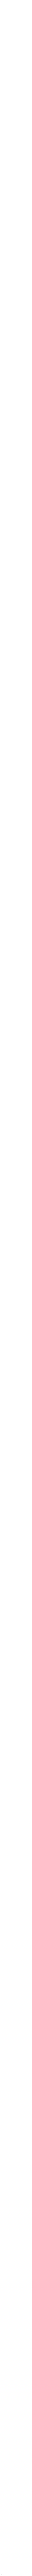

In [24]:
train(diffusion_imputer, data_loader_model[0], epochs = 200, lr = 0.1, loss_func = diffusion_imputer.loss_func)

In [52]:
#save the entire model for further training
torch.save(diffusion_imputer, "diffusion_imputer.pt")


(diffusion_imputation(
   (data_embedding_linear): Sequential(
     (0): Linear(in_features=1, out_features=128, bias=True)
     (1): ReLU()
     (2): Linear(in_features=128, out_features=128, bias=True)
   )
   (diffusion_embedding): DiffusionEmbedding(
     (projection1): Linear(in_features=128, out_features=128, bias=True)
     (projection2): Linear(in_features=128, out_features=128, bias=True)
   )
   (time_embedding): TimeEmbedding(
     (learnable): Sequential(
       (0): Linear(in_features=128, out_features=128, bias=True)
       (1): SiLU()
       (2): Linear(in_features=128, out_features=128, bias=True)
     )
   )
   (feature_embedding): FeatureEmbedding(
     (learnable): Sequential(
       (0): Linear(in_features=128, out_features=128, bias=True)
       (1): SiLU()
       (2): Linear(in_features=128, out_features=128, bias=True)
     )
   )
   (embedding_conv): Conv1d(4, 1, kernel_size=(1,), stride=(1,))
   (transformer): TransformerEncoder(
     (encoder_modules): ModuleL

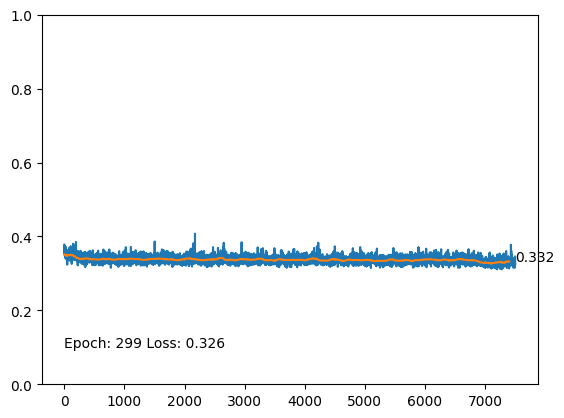

In [29]:
train(diffusion_imputer, data_loader_model[0], epochs = 300, lr = 0.0001, loss_func = diffusion_imputer.loss_func)

In [30]:
#save the entire model for further training
torch.save(diffusion_imputer, "diffusion_imputer.pt")


# Evaluation

In [26]:
# load the model
#diffusion_imputer = torch.load("diffusion_imputer.pt")

In [52]:
diffusion_imputer.state_dict()

OrderedDict([('data_embedding_linear.0.weight',
              tensor([[ 0.0983],
                      [-0.0494],
                      [ 0.0057],
                      [ 0.0572],
                      [ 0.0237],
                      [-0.0398],
                      [ 0.0559],
                      [-0.0024],
                      [-0.0177],
                      [-0.0240],
                      [ 0.1433],
                      [ 0.0153],
                      [-0.0242],
                      [ 0.1886],
                      [ 0.0718],
                      [-0.0206],
                      [ 0.1494],
                      [-0.0222],
                      [ 0.0278],
                      [-0.0140],
                      [ 0.0594],
                      [-0.0758],
                      [-0.0153],
                      [-0.0545],
                      [ 0.0645],
                      [-0.0879],
                      [ 0.0303],
                      [-0.0044],
                      [ 0.05

In [134]:
test_set[0]["observed_data"].shape

(36, 36)

In [54]:
#let's try to impute the data
test_data = torch.tensor(test_set[0]["observed_data"]).to("cuda").unsqueeze(0)
#imputation_mask = diffusion_imputation.get_mask(diffusion_imputer, test_data, "random").to("cuda")
imputation_mask =  torch.zeros_like(test_data.unsqueeze(3)).to("cuda")
imputation_mask[:, 34:35, :, :] = 1
#imputation_mask = imputation_mask.squeeze(3)
given_points = test_data * (1-imputation_mask)
eval_points = test_data * imputation_mask

#impute the data
imputed_samples = diffusion_imputation.eval(diffusion_imputer, test_data, imputation_mask)
#print(imputed_samples)

tensor([-0.3891, -0.4164,  0.7522,  ..., -0.0613, -0.7124,  0.3517],
       device='cuda:0', grad_fn=<IndexBackward>)
tensor([-29718.0963,   9041.8375,  11377.6361,  ...,    561.4991,
        -22743.1994,   1231.7194], device='cuda:0', dtype=torch.float64)


In [ ]:
imputed_samples[imputation_mask==1]

NameError: name 'imputed_samples' is not defined

In [43]:
test_data[imputation_mask==1]

tensor([-0.6398,  0.8585,  2.1010, -0.2769, -0.6833,  0.8999,  1.8968, -0.5842,
         2.0009, -0.9107, -0.8718, -0.8836, -0.7147, -0.7804, -0.7165, -0.9723,
        -0.9435,  1.7304,  1.5737, -0.9510, -0.9200, -0.9204, -0.5334, -0.3424,
        -0.6833,  0.6008, -0.8051, -0.8295, -0.7789,  1.0458, -0.0340, -0.2806,
        -0.7688,  1.2980, -0.1599, -0.0508, -0.3548, -0.2648, -0.1997, -0.1881,
        -0.3042, -0.3204, -0.2640,  0.1016,  0.1757, -0.3721, -0.4809, -0.5805,
        -0.8225, -0.6434, -0.6847, -0.7030, -0.7793, -0.7176, -0.9151, -0.6308,
        -0.6317, -0.9112, -0.8641, -1.0195, -0.9200, -0.7689, -0.6689, -0.9873,
        -0.9012, -0.7733, -0.8834, -0.9481, -0.9319, -0.8295, -0.6475, -0.7748,
        -0.8507, -0.7846, -0.8967, -0.8816, -0.7448, -0.7244, -0.7131, -0.7019,
        -0.7117, -0.7772, -0.8381, -0.6626, -0.5636, -0.5860, -0.6729, -0.4165,
        -0.4951, -0.4458, -0.4907, -0.4088, -0.3630, -0.3962, -0.6210, -0.2813,
        -0.1208, -0.2771, -0.0928, -0.26

In [27]:
sample_number = 40
samples = []
for i in range(sample_number):
    samples.append(diffusion_imputer.eval(test_data, imputation_mask))


RuntimeError: [enforce fail at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\c10\core\impl\alloc_cpu.cpp:72] data. DefaultCPUAllocator: not enough memory: you tried to allocate 859963392 bytes.

In [ ]:
qlist =[0.05,0.25,0.5,0.75,0.95]
quantiles_imp= []
for q in qlist:
    quantiles_imp.append(torch.quantile(samples, q, dim=1).cpu().numpy()*(1-given_points) + test_data * given_points)

In [ ]:
import matplotlib.pyplot as plt

In [ ]:
L = test_data.shape[1]
K = test_data.shape[2]

###airquality###
dataind = 10 #change to visualize a different sample

plt.rcParams["font.size"] = 16
fig, axes = plt.subplots(nrows=9, ncols=4,figsize=(24.0, 36.0))
fig.delaxes(axes[-1][-1])

for k in range(K):
    df = pd.DataFrame({"x":np.arange(0,L), "val":test_data[dataind,:,k], "y":eval_points[dataind,:,k]})
    df = df[df.y != 0]
    df2 = pd.DataFrame({"x":np.arange(0,L), "val":test_data[dataind,:,k], "y":given_points[dataind,:,k]})
    df2 = df2[df2.y != 0]
    row = k // 4
    col = k % 4
    axes[row][col].plot(range(0,L), quantiles_imp[2][dataind,:,k], color = 'g',linestyle='solid',label='CSDI')
    axes[row][col].fill_between(range(0,L), quantiles_imp[0][dataind,:,k],quantiles_imp[4][dataind,:,k],
                    color='g', alpha=0.3)
    axes[row][col].plot(df.x,df.val, color = 'b',marker = 'o', linestyle='None')
    axes[row][col].plot(df2.x,df2.val, color = 'r',marker = 'x', linestyle='None')
    if col == 0:
        plt.setp(axes[row, 0], ylabel='value')
    if row == -1:
        plt.setp(axes[-1, col], xlabel='time')